# Time series analysis using XGBoost

In [135]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error as mse
# OS
from pathlib import Path

# Styling
color_pal = sns.color_palette("Set2")
plt.style.use('seaborn-v0_8-colorblind')

ModuleNotFoundError: No module named 'xgboost'

In [2]:
data_path = Path('data/PJME_hourly.csv')

In [3]:
df = pd.read_csv(data_path)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [5]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [6]:
df.tail()

,Datetime,PJME_MW
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0
145365,2018-01-02 00:00:00,38608.0


# Data Cleaning

- set index
- typecast

In [12]:
df.set_index('Datetime', inplace=True)
df.index = pd.to_datetime(df.index)

KeyError: "None of ['Datetime'] are in the columns"

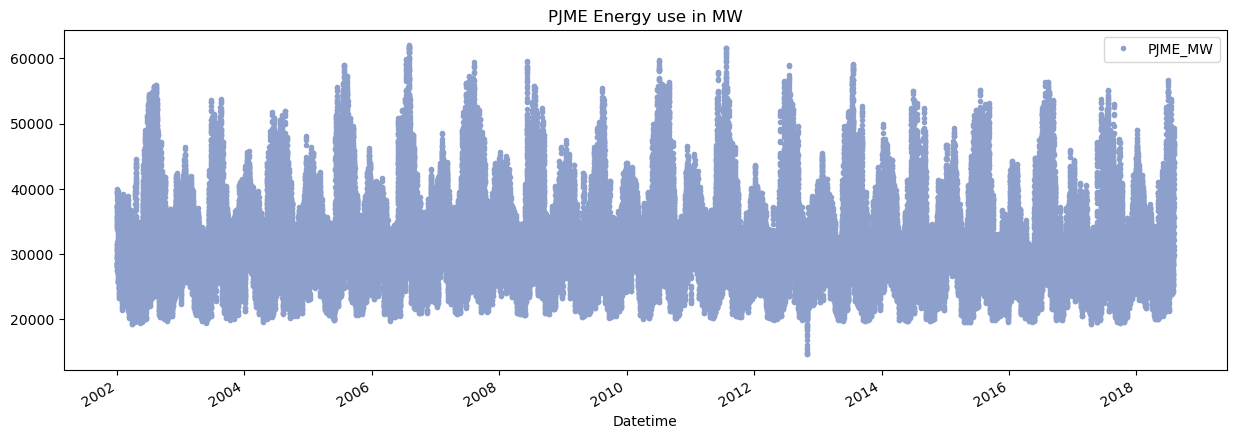

In [11]:
df.plot(title='PJME Energy use in MW',
        style='.',
        figsize=(15,5),
        use_index=True,
        color=color_pal[2])
plt.show()

# Train Test Split

In [16]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

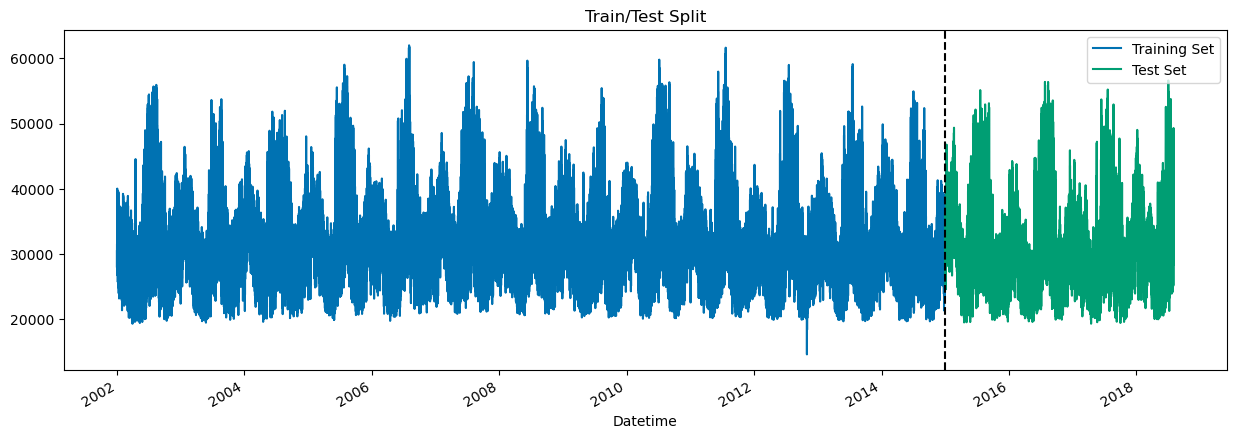

In [19]:
fig, ax = plt.subplots(figsize=(15,5))

train.plot(ax=ax, label='Train', title='Train/Test Split')
test.plot(ax=ax, label='Test')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'], loc='upper right')
plt.show()

<Axes: title={'center': 'Week of Data'}, xlabel='Datetime'>

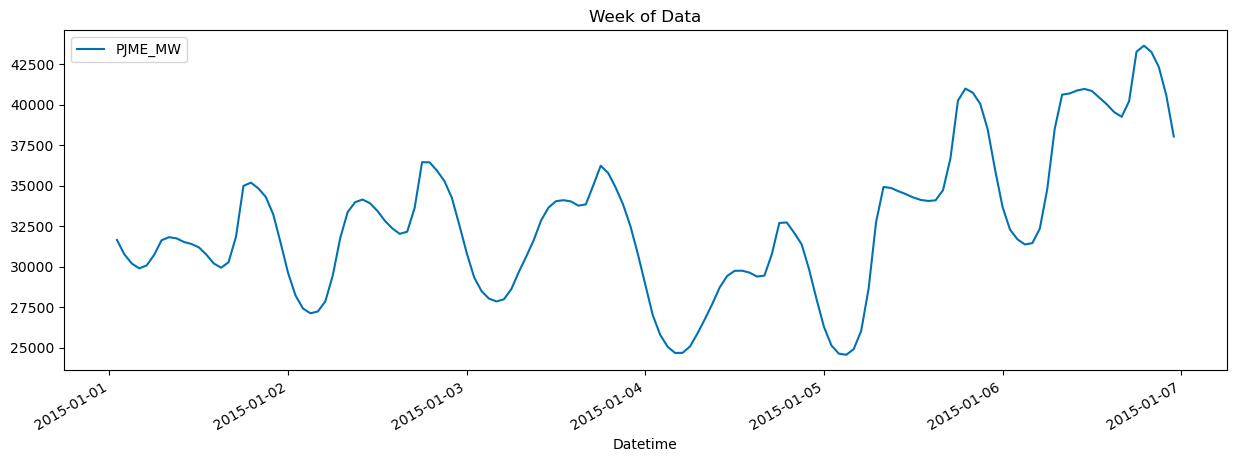

In [34]:
# visualising one week
df.loc[(df.index >'01-01-2015') & (df.index < '01-07-2015')] \
    .plot(figsize=(15,5), title='Week of Data') # note & denotes element-wise logical, whereas 'and' will ask python to typecast into bool

# Feature Creation

In [35]:
def create_features(df):
    """
    Create time series features given df with datetim index
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [36]:
df = create_features(df)

# Visalising Feature / Target Relationship

In [50]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear'],
      dtype='object')

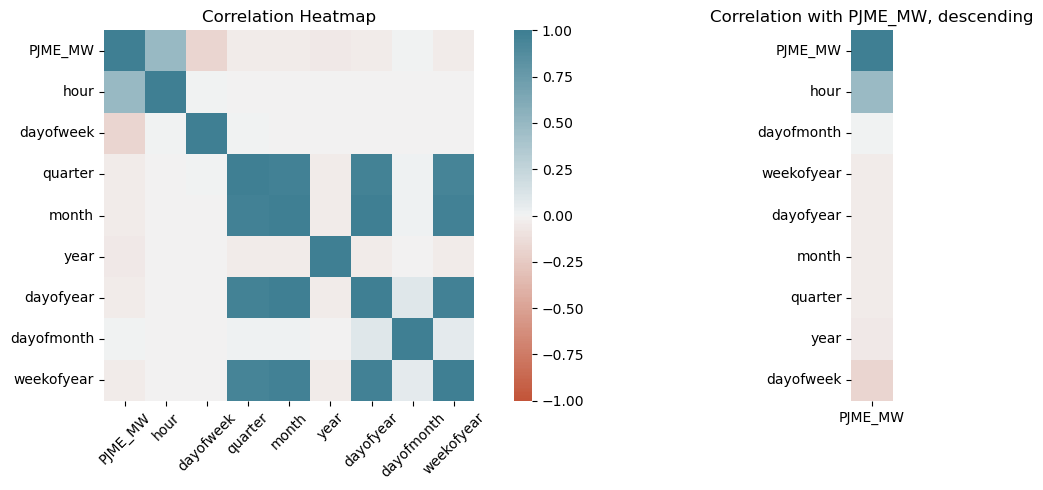

In [102]:
corr = df.corr() 
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
fig.subplots_adjust(hspace=-0.5, top=0.9, left=0.1)
ax1 = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200), 
    square=True,
    ax = ax1
)
ax1.set_xticklabels(
    ax1.get_xticklabels(),
    rotation=45,
    # horizontalalignment='right'
)
ax1.set_title('Correlation Heatmap')

# plotting correlation with target
corr_target = df.corr()[['PJME_MW']].sort_values(by=['PJME_MW'],ascending=False)
ax2 = sns.heatmap(corr_target,
                  vmin=-1, vmax=1, 
                  cmap=sns.diverging_palette(20, 220, n=200),
                  square=True,
                  cbar=False,
                  ax=ax2)
ax2.set_title('Correlation with PJME_MW, descending');
plt.tight_layout()

In [109]:
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1
...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1,1,1
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1,1,1
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1,1,1


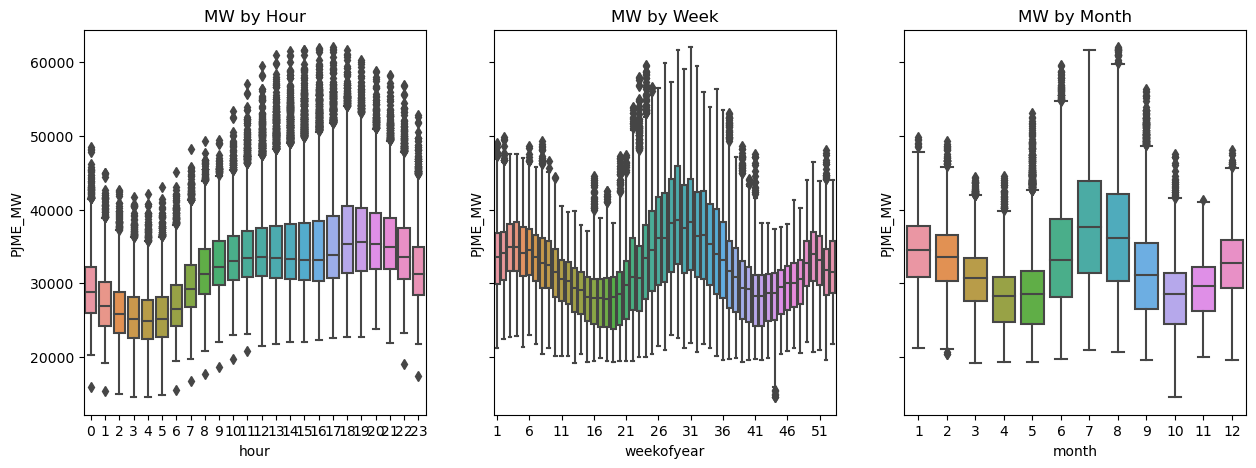

In [130]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5), sharey=True)
sns.boxplot(data=df, x='hour', y='PJME_MW', ax=ax1)
ax1.set_title('MW by Hour')

sns.boxplot(data=df, x='weekofyear', y='PJME_MW', ax=ax2)
ax2.set_title('MW by Week')
# Set ticks every 4 week
ax2.xaxis.set_major_locator(plt.MaxNLocator(12))

sns.boxplot(data=df, x='month', y='PJME_MW', ax=ax3)
ax3.set_title('MW by Month');

# Model Creation

In [131]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]